In [972]:
# !pip install openpyxl

# Insurance Final Project - Solvency II

$\textit{MSc Mathematical Engineering - Track Quantitative Finance}$, $\textbf{Politecnico di Milano}$.

$\textit{Noé Debrois}$ \&$\textit{Vincent Haïk Karakoseian}$, $\textbf{March-April 2024}$.

### Step 0 : Import the libraries

In [973]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Step 1 : Simulate the fund made of 80% equity and 20% property using GBM :

Risk Neutral Geometric Brownian motion (GBM) S is defined by S0 > 0 and the dynamics as defined in the following Stochastic Differential Equation (SDE):


$\Large dS_t = r_t S_t dt + \sigma S_t dW_t$

Integrated Form:

 - $\log S_t = \log S_0 + \int_{0}^{t} (r_t-\frac{\sigma^2}{2}) \,ds + \int_{0}^{t} \sigma \,dW_s $

 - i.e : $\log S_t = \log S_0 + (r_t-\frac{\sigma^2}{2})t + \sigma W_t $

 - i.e : $\log S_t \sim N(\log S_0 + (r_t-\frac{\sigma^2}{2})t, \sigma^2 t)$

Explicit Expression:

$\Large S_t = S_0 {\rm e}^{(r_t-\frac{\sigma^2}{2})t + \sigma W_t}$

With $r_t$ being derived from RFR EIOPA withou VA. It is imported below.

In [974]:
# Path to your Excel file
file_path = 'EIOPA/EIOPA_RFR_20240229_Term_Structures.xlsx'

# Read Excel file
df = pd.read_excel(file_path, "RFR_spot_no_VA", usecols="S", )
df = df[9:]
df = df.rename(columns={'Unnamed: 18': 'EIOPA IT without VA, FEB'})
rt = np.array(df).T
rt = np.array(rt, np.float64)

#### Function to simulate Risk Neutral GBM paths :

In [975]:
def simulate_gbm(F0, r, sigma, dt, N, m_MC):
    # Generate N samples from a GBM with risk-free rate r and volatility sigma
    # r and sigma are assumed to be annualized
    # dt is the time step
    # S0 is the initial value of the process
    S = np.zeros((m_MC,N))
    S[:,0] = np.full(m_MC, F0)
    for iter in range(m_MC):
        for t in range(1, N):
            # Generate random normal variable
            z = np.random.normal()
            # Update the stock price
            S[iter,t] = S[iter,t-1] * np.exp((r[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return S

def simulate_gbm_vec(F0, r, sigma, dt, N, m_MC):
    # Generate N samples from a GBM with risk-free rate r and volatility sigma
    # r and sigma are assumed to be annualized
    # dt is the time step
    # S0 is the initial value of the process
    S = np.zeros((m_MC, N))
    S[:, 0] = np.full(m_MC, F0)
    for t in range(1, N):
        # Generate m_MC samples of random normal variables
        z = np.random.normal(size=m_MC)
        # Update the stock price for all iterations simultaneously
        S[:, t] = S[:, t - 1] * np.exp((r[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return S

#### Fix the parameters for the simulation :

In [976]:
# Parameters
m_MC = 100 # Number of simulations
T = 50 # Time horizon in years
N = 50 # Number of time steps (daily frequency)
dt = T / N # Time step
F0 = 100000 # Initial value of the fund
sigma_equity = 0.20 # Volatility for equity
sigma_property = 0.10 # Volatility for property
rt = rt[0, :N] # Time-varying risk-free rate
PR_weight = 0.2 # Weight of PR in the portfolio
EQ_weight = 0.8 # Weight of EQ in the portfolio

#### Simulation :

In [977]:
# Simulate equity and property paths
EQt= simulate_gbm_vec(F0, rt, sigma_equity, dt, N, m_MC)
PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, m_MC)

# Calculate the fund value at each time step
fund_value = EQ_weight * EQt + PR_weight * PRt

#### Plot the value of our portfolio vs time :

(50, 100)(50, 100)


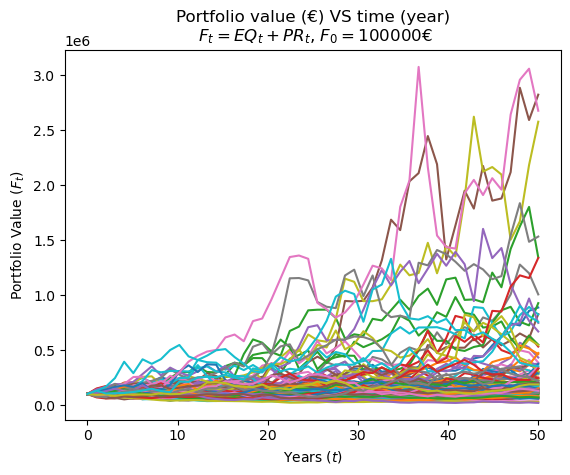

In [982]:
# Define time interval correctly
time = np.linspace(0,T,N)
# Require numpy array that is the same shape as Ft
tt = np.full(shape=(m_MC,N), fill_value=time).T
# Check that the dimensions are OK for the plot
print(str(tt.shape) + str(fund_value.T.shape))

plt.plot(tt, fund_value.T);
plt.xlabel("Years $(t)$")
plt.ylabel("Portfolio Value $(F_t)$")
plt.title("Portfolio value (€) VS time (year)\n $F_t = EQ_t + PR_t$, $F_0 = 100000€$")
plt.show()